## Analysis of pandemic dynamics assuming SIR-like evolution
### Carlos Ignacio Herrera-Nolasco$^{1}$, Marco Arieli Herrera-Valdez$^{1}$
#### $^{1}$ Laboratorio de Fisiología de Sistemas, Facultad de Ciencias, UNAM


### Epidemic dynamics 

Assume that the population is divided in three subsets representing the non-infected and susceptible, the infected, and those that can no-longer participate in the chain of infections due to immunity or death. 
Let the densities of those subpopulations be represented by $x$, $y$, and $z$ respectively, with $1=x+y+z$. As a consequence,  $\partial_t x = -\partial_t y - \partial_t z$. Let  $\alpha$ represent the infection rate given an infectious contact, and $\tau$ the average waiting time until an individual is no longer infected. The dynamics for $y$ can be written as 
\begin{equation}
\partial_t y = \alpha y \bigg( 1- z - y \bigg) - \beta y,
\end{equation}
and the evolution for $z$ is then
\begin{equation}
\partial_t z = \beta y
\end{equation}

The incidence of cases is the number of new infected. From the equation for the change in $y$, the incidence is given by  $$f(y,z;\alpha) =\alpha y \bigg( 1- z - y \bigg),$$ which means that the incidence in the SIR model is a cuadratic function of the prevalence, but it also depends on $z$, the density of no-longer infected people. Since $z$ is an increasing function, then the graph of the incidence can be thought of as a curve in 3D space with quadratic shape. 


#### Parameters for modeling 
If $\gamma$ is the rate of removal by recovery and acquisition of immunity and $\delta$ is the fatality rate due to infection, we can try to obtain the parameters for the model from the data. To do so, consider the equation for $z$ to obtain,
\begin{equation}\beta = \frac{\partial_t z}{y},\end{equation} 
and also 
\begin{equation}\alpha = \frac{\partial_t y + \partial_t z}{y \bigg( 1 -z - y  \bigg)}. \end{equation} 
The problem is then to link the data to the variables $y$ and $z$.

### Linking the data to the modeling variables 

If $h$ is the time step for sampling, let $Y_{n}$ represent the number of cases at time $t=nh$. Note that $Y_n$ may be thought of in terms of the density of cases $y_n$. Explicitly, $y_n = Y_n/T $ here $T$ is the size of the local population.  From data, the cumulative number of cases at step $nh$ can be written as 
$$C_{n} = \sum_{k=0}^{n} Y_k$$
which means that the number of new cases (incidence) at time nh is 
$$Y_n = C_n - C_{n-1}.$$
The cumulative recoveries and deaths are 
$$Z_n = R_{n}+D_{n}.$$
The incidence is then 
$$C_n - R_n - D_n$$

#### Parameters for modeling 
We can try to obtain the parameters for the model from the data by approximated by substitution of the discrete differences 
$$
\partial_t y \approx \frac{u(t+h)-u(t)}{h},  \quad u \in \left\{Y,Z \right\}
$$
The parameters $\alpha$ and $\beta$ can then be estimated from the data. 


In [1]:
import sys
sys.path.insert(1, '../')
from dam_COVID19_baseCode import *
import matplotlib.pylab as gr
small={'family' : 'normal','weight' : 'normal','size'   : 8}
medium={'family' : 'normal','weight' : 'normal','size'   : 10}
large={'family' : 'normal','weight' : 'bold','size'   : 13}
gr.rc('font', size=small['size'], weight='normal')          # controls default text sizes
gr.rc('axes', titlesize=medium['size'])     # fontsize of the axes title
gr.rc('axes', labelsize=medium['size'])    # fontsize of the x and y labels
gr.rc('xtick', labelsize=small['size'])    # fontsize of the tick labels
gr.rc('ytick', labelsize=small['size'])    # fontsize of the tick labels
gr.rc('legend', fontsize=small['size'])    # legend fontsize
gr.rc('figure', titlesize=large['size'])  # fontsize of the figure title
%matplotlib inline 

Data for Mexico obtained from http://187.191.75.115/gobmx/salud/datos_abiertos/datos_abiertos_covid19.zip
Data obtained from https://github.com/CSSEGISandData/COVID-19/


In [27]:
cases, deathCases,recovCases = getCSSEGISandData(urlData=1)

In [29]:
cases.head(10)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,933,996,1026,1092,1176,1279,1351,1463,1531,1703
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,548,562,584,609,634,663,678,712,726,736
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,2534,2629,2718,2811,2910,3007,3127,3256,3382,3517
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,704,713,717,717,723,723,731,738,738,743
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,24,24,24,24,25,25,25,25,26,27
5,NaN,Antigua and Barbuda,17.0608,-61.7964,0,0,0,0,0,0,...,23,23,23,23,24,24,24,24,24,24
6,NaN,Argentina,-38.4161,-63.6167,0,0,0,0,0,0,...,2758,2839,2941,3031,3144,3435,3607,3780,3892,4003
7,NaN,Armenia,40.0691,45.0382,0,0,0,0,0,0,...,1248,1291,1339,1401,1473,1523,1596,1677,1746,1808
8,Australian Capital Territory,Australia,-35.4735,149.0124,0,0,0,0,0,0,...,103,103,104,104,104,104,105,106,106,106
9,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,...,2936,2957,2963,2969,2971,2976,2982,2994,3002,3004


In [30]:
# ------------------------------
# Description of the data so that the headers and the columns
# without case data are distinguished
# ------------------------------
nRows,nCols=cases.shape
cases.head(10)
nHeaderRows=1;
#
nHeaderCols=3
# how to generate date lists from a baseline using the datetime
dates = cases.columns[4:]
nDays = len(dates)
days = np.arange(nDays)
print('Got data from %d days between %s and %s'%(nDays,dates[0],dates[-1]))
# -------------------
print("""""")
# -------------------
npCases = cases.to_numpy()
countries = np.unique(npCases[:,1])
nCountries = len(countries)
print('Considering data from {d} countries'.format(d=nCountries))
# -------------------
# Gather same country data
# -------------------
gCases, countries_Cases= sortDataByCountry(cases, nHeaderCols)
gDeaths,countries_DeathCases = sortDataByCountry(deathCases, nHeaderCols)
gRecovCases,countries_RecovCases = sortDataByCountry(recovCases, nHeaderCols)
# -------------------
# Sum the counts from each country and construct a new array
# -------------------
# These arrays have the same size as the countries array (unique countries)
totCases=gatherDataByCountry(df=cases,nHeaderCols=4)
totDeathCases=gatherDataByCountry(df=deathCases,nHeaderCols=4)
totRecovCases=gatherDataByCountry(df=recovCases,nHeaderCols=4)
G = {'cCases':totCases,'cDeaths':totDeathCases,'cRecovs':totRecovCases,'countries':countries}
# -------------------
# Search regions to illustrate the case-fatality ratios
# -------------------
Pops_Millions = {'Algeria':43851044, 'Argentina':45195774,'Australia':25499884,'Belgica':11433256,
                 'Brazil':212559417, 
                 'Canada':37742154, 'China':1439323776, 'Colombia':50882891,'Egypt':102334404,
                 'France':67886011,'Germany':83783942, 'Japan':126476461,'Korea, South':51269185,
                 'Indonesia':273523615, 'Iran':83992949,'Israel':8655535,'Italy':60461826,
                 'Mexico':128932753, 'Niger':24206644, 'Singapore':5850342, 
                 'South Africa':59308690,'Spain':46754778,
                 'United Kingdom':67886011, 'US':331002651, 'Venezuela':28870195}

Got data from 97 days between 1/22/20 and 4/27/20

Considering data from 185 countries


In [31]:
print(type(totCases))
print(totCases.shape)

<type 'numpy.ndarray'>
(185, 97)


#### Parabola describing the incidence as a function of the cases

In [32]:
def getSingleCountryData(countries, cou):
    cInd = np.where(countries==cou)[0][0]
    tCases= np.float64(totCases[cInd,:])/Pops_Millions[cou]
    
def data(cumInfected, cumRemoved, Pops_Millions, cou='Italy'):
    cInd = np.where(countries==cou)[0][0]
    tCases= np.float64(totCases[cInd,:])/Pops_Millions[cou]
    z=np.float64(deathsRecovs[cInd,:])/Pops_Millions[cou]
    tRecovs=np.float64(totRecovCases[cInd,:])/Pops_Millions[cou]
    # Prevalence time series
    y = tCases - tRecovs - tDeaths # The time series of cumulative cases without cumulative recovs 
    # "Prevalence" of deaths and recoveries 
    z = tRecovs + tDeaths
    dy=np.zeros(len(z)); dy[1:]= y[1:]-y[:1]
    dz=np.zeros(len(z)); dz[1:]= z[1:]-z[:1]
    fy = a*y*(1-z-y) 
    return y,z,dy,dz

def gammaDelta_Estimate(y, dz):
    return (dz/y)

def betaEstimate(y,z,dy, dz):
    return (dy+dz)/((1-z-y)*y)

def dataIncidence(dy,dz):
    # Incidence 
    inc = dy - dz
    
def incidenceSIR(y,z,a):
    # Incidence 
    fy = a*y*(1-z-y) 
    return 
    
def plotDataPhasePortraits(y,z,dy,dz):
    ff =gr.figure(figsize=(17,5)); gr.ioff(); rows=1; cols=3
    ax1= ff.add_subplot(rows,cols,1); tax1= ax1.twinx()
    ax2= ff.add_subplot(rows,cols,2); 
    ax3= ff.add_subplot(rows,cols,3); 
    ax1.plot(days, y,'o',markeredgecolor='blue', markerfacecolor='white',label=r'$y_k$')
    #ax1.plot(days, tCases,'.',label=r'$(k,C_k)$')
    tax1.plot(days, beta/gammaDelta,'.',label=r'$\beta/\gamma$')
    ax1.plot(days, tDeaths,'.',label=r'$D_k$')
    ax1.plot(days, tRecovs,'.',label=r'$R_k$')
    ax1.plot(days, z,'.',label=r'$z_k=D_k + R_k$')
    ax2.plot(dy,y,'o',markeredgecolor='blue', markerfacecolor='white',label=r'$(y_k - y_{k-1}, y)$')
    ax2.plot(fy,y,'.',color='orange',label=r'$(a (b-z-y)y,y)$')
    ax3.plot(1-z-y,y,'.',label=r'$(1-z-y, y)$')
    ax2.plot([0,0],[0,y.max()],'k:')
    ax1.set_ylim(0,1.1* y.max())
    ax2.set_ylim(0,1.1* y.max())    
    ax2.set_xlim(dy.min(),1.3*dy.max())
    ax1.set_xlabel(r'$t$ (days)');ax2.set_xlabel(r'$y_k - y_{k-1}$')
    ax1.set_ylabel(r'$y_k$');ax2.set_ylabel(r'$y_k$')
    ax2.legend(loc='lower right'); ax3.legend(loc='upper right'); 
    ax1.legend(loc='center left'); tax1.legend(loc='upper left')
    gr.ion(); gr.draw()
    ff.suptitle('Phase plane, %s'%cou)
    ff.subplots_adjust(left=0.075,bottom=0.075,right=0.9,top=0.92,wspace=0.2,hspace=0.25)
    ff.savefig('figures_COVID19_dataAnalysis/dam_COVID19_JHU_phasePlane_%s.png'%cou)
    return y, z, dy, dz, beta, gammaDelta, ff



/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in divide


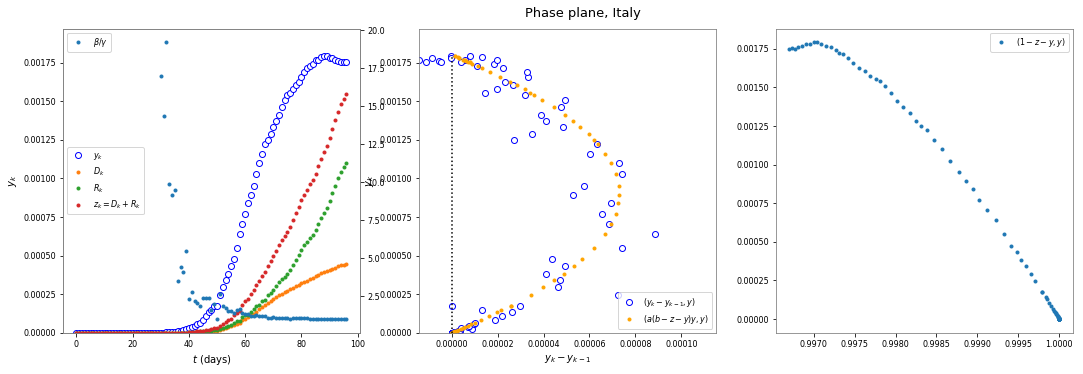

In [33]:
y,z, dy,dz,beta,gammaDelta,ff=casePhasePlane(cou='Italy',b=0.0018,a=90)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in divide
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in divide


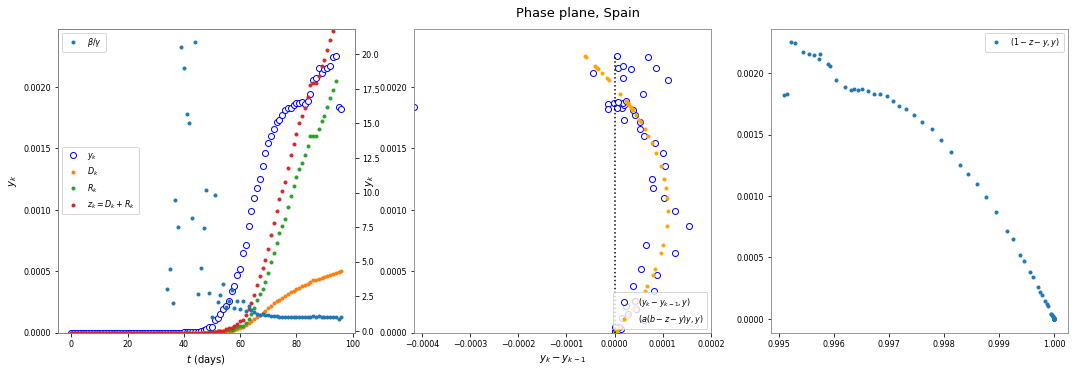

In [34]:
y,z, dy,dz,beta,gammaDelta,ff=casePhasePlane(cou='Spain',b=0.002,a=110)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in divide


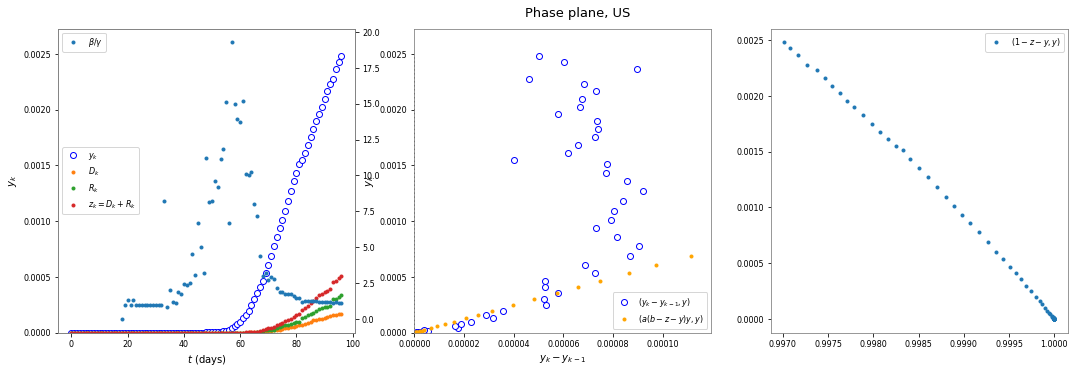

In [35]:
y,z, dy,dz,beta,gammaDelta,ff=casePhasePlane(cou='US',a=0.0023,b=70)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in divide


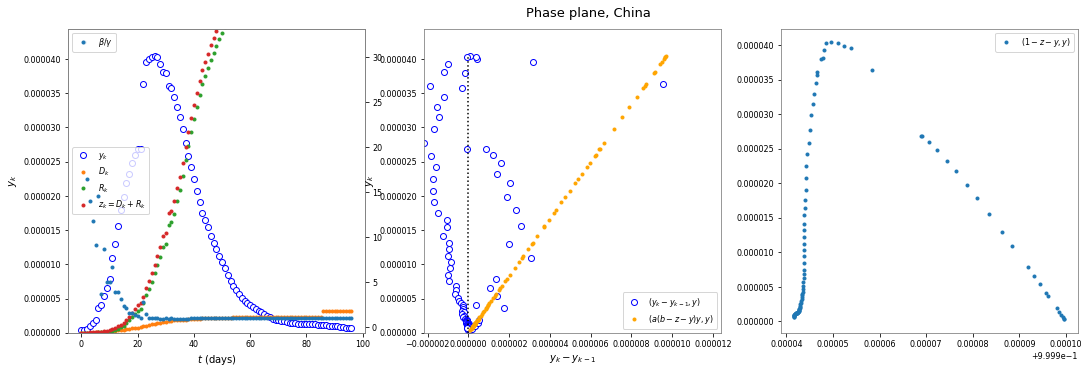

In [36]:
#y,z, dy,dz,beta,gammaDelta,ff=casePhasePlane(cou='Italy',a=0.00175,b=90)
y,z, dy,dz,beta,gammaDelta,ff=casePhasePlane(cou='China',a=0.00004,b=6000)
#print((1-y-z)*beta/gammaDelta )


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in divide


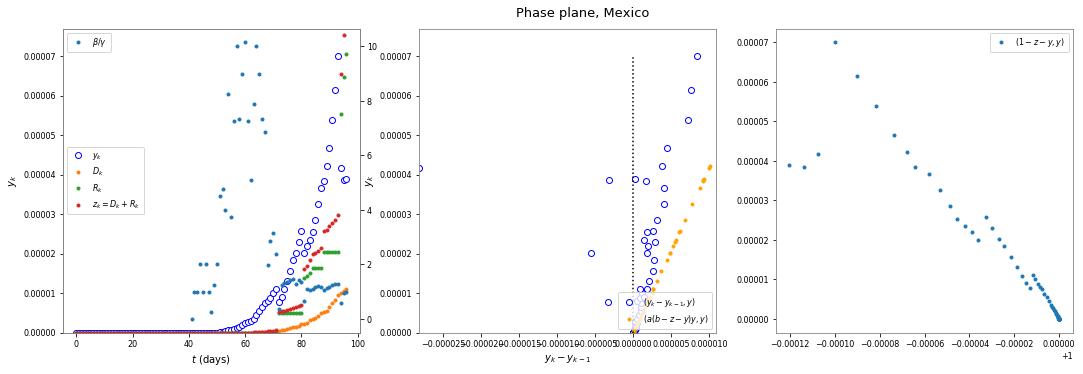

In [37]:
y,z, dy,dz,beta,gammaDelta,ff=casePhasePlane(cou='Mexico',a=0.00006,b=4000)